# Leverage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrix

In [2]:
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)

In [94]:
# レバレッジの計算
class LeverageCalculator:
    def __init__(self, X, data):
        self.X = X
        self.data = data

    def get_leverage(self):
        # ハット行列 H の計算
        H = self.X @ np.linalg.inv(self.X.T @ self.X) @ self.X.T
        # 対角要素を取得
        leverage = np.diag(H)

        self.data['leverage'] = leverage

        return self.data

    def describe_leverage(self):
        if 'leverage' not in self.data.columns:
            self.get_leverage()

        mean_leverage = self.data['leverage'].mean()
        sd_leverage = self.data['leverage'].std()
        min_leverage = self.data['leverage'].min()
        median_leverage = self.data['leverage'].median()
        max_leverage = self.data['leverage'].max()

        leverage_describe = {
            'mean': mean_leverage.round(3),
            'sd': sd_leverage.round(3),
            'min': min_leverage.round(3),
            'median': median_leverage.round(3),
            'max': max_leverage.round(3)
        }

        return leverage_describe

    def plot_leverage(self, figsize=(10, 5)):
        if 'leverage' not in self.data.columns:
            self.get_leverage()

        mean_leverage = self.data['leverage'].mean()

        fig, ax = plt.subplots(figsize=figsize)
        sns.scatterplot(
            x=self.data.index,
            y='leverage',
            data=self.data,
            color='black',
            ax=ax
        )
        ax.set_xlabel('Index')
        ax.set_ylabel('Leverage')
        ax.set_title('Leverage')
        ax.axhline(mean_leverage, color='black', linestyle='--', label='Mean')
        ax.axhline(2 * mean_leverage, color='black', linestyle='-.', label='2 $\\times$ Mean')
        ax.axhline(5 * mean_leverage, color='black', linestyle=':', label='5 $\\times$ Mean')
        ax.legend()

        return fig, ax
    
    def get_high_leverage(self, threshold=2):
        if 'leverage' not in self.data.columns:
            self.get_leverage()

        high_leverage_islands = self.data[self.data['leverage'] > threshold * self.data['leverage'].mean()][['island_ids', 'leverage', 'treatment_group', 'after_treatment']]
        return high_leverage_islands

In [95]:
X = dmatrix('C(island_ids) + C(year) + after_treatment -1', df)
twfe_calculator = LeverageCalculator(X, df)
X = dmatrix('C(island_ids) + C(year) + treatment_group:C(time_since_treatment) -1', df)
dynamic_calculator = LeverageCalculator(X, df)
X = dmatrix('C(island_ids) + C(year) + treatment_group:C(time_since_treatment):C(bridge_year) -1', df)
fs_calculator = LeverageCalculator(X, df)


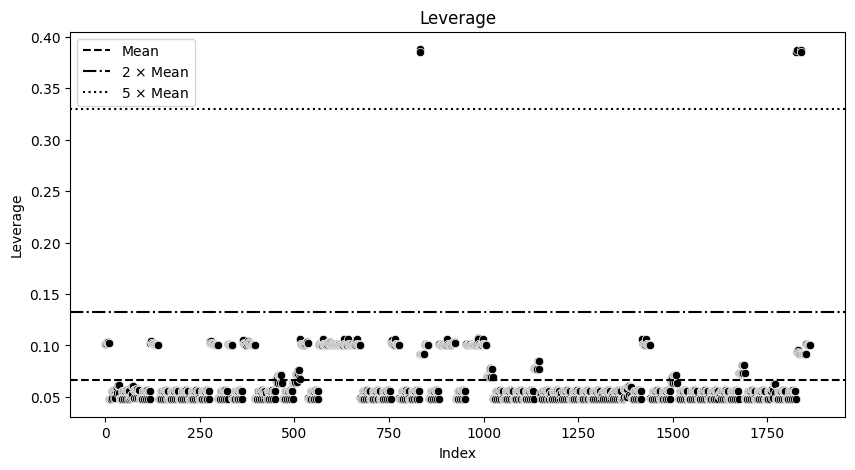

In [92]:
fig, ax = fs_calculator.plot_leverage()

In [97]:
twfe_calculator.describe_leverage()

{'mean': 0.066, 'sd': 0.027, 'min': 0.048, 'median': 0.056, 'max': 0.388}

In [96]:
fs_calculator.describe_leverage()

{'mean': 0.066, 'sd': 0.027, 'min': 0.048, 'median': 0.056, 'max': 0.388}

In [88]:
twfe_calculator.get_high_leverage(threshold=5)

,island_ids,leverage,treatment_group,after_treatment
831,138,0.387851,1,1
832,138,0.385012,1,1
1826,221,0.384745,1,0
1827,221,0.386953,1,0
1839,223,0.386686,1,0
1840,223,0.385424,1,1
